In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im DAX

Zunächst werden die Kursdaten für den DAX geladen und bereinigt

In [2]:
SYMBOL = "^GDAXI"

stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren für spätere Auswertungen

In [3]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [4]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# add countdown
end_of_month["countdown"] = -1
end_of_month["days"] = end_of_month["countdown"].cumsum().add(1).mod(days)
end_of_month.loc[end_of_month.days == 0, "days"] = days
end_of_month["days"] = end_of_month["days"] * -1

beginning_of_month["countdown"] = 1
beginning_of_month["days"] = beginning_of_month["countdown"].cumsum().mod(days)
beginning_of_month.loc[beginning_of_month.days == 0, "days"] = days

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold", "days"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

## Jetzt zur Strategie
Es wird 5 Tage vor Monatsende gekauft und 5 Tage nach Monatsanfang gekauft

In [5]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    days_before = -5
    days_after = 5

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if self.data.days[-1] == self.days_before:
            self.buy()

In [6]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":], end_of_month, cash=100_000, commission=0.002, trade_on_close=True
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-02 00:00:00
End                       2024-04-17 00:00:00
Duration                   4489 days 00:00:00
Exposure Time [%]                   47.319422
Equity Final [$]                111708.923732
Equity Peak [$]                 116502.512254
Return [%]                          11.708924
Buy & Hold Return [%]              193.735337
Return (Ann.) [%]                    0.899788
Volatility (Ann.) [%]               11.445157
Sharpe Ratio                         0.078617
Sortino Ratio                        0.110913
Calmar Ratio                         0.026935
Max. Drawdown [%]                  -33.406234
Avg. Drawdown [%]                   -5.246466
Max. Drawdown Duration     2889 days 00:00:00
Avg. Drawdown Duration      231 days 00:00:00
# Trades                                  148
Win Rate [%]                        56.756757
Best Trade [%]                      12.313994
Worst Trade [%]                    -12.822212
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

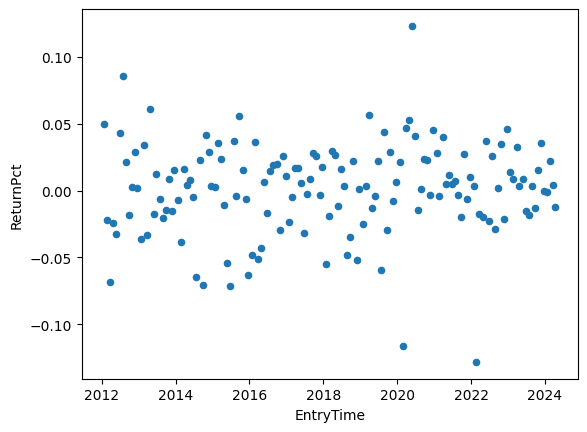

In [7]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

In [8]:
trades[trades.ReturnPct < -0.05]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
2,14,60,69,7093.388440,6606.430176,-6817.415705,-0.068650,2012-03-26,2012-04-10,15 days
30,10,648,657,9663.297785,9038.969727,-6243.280586,-0.064608,2014-07-25,2014-08-07,13 days
32,10,691,700,9681.293666,8995.330078,-6859.635879,-0.070855,2014-09-24,2014-10-08,14 days
40,8,854,863,11838.639785,11197.150391,-5131.915156,-0.054186,2015-05-22,2015-06-05,14 days
41,8,876,885,11494.202285,10676.780273,-6539.376094,-0.071116,2015-06-24,2015-07-07,13 days
47,9,1005,1014,10509.727500,9849.339844,-5943.488906,-0.062836,2015-12-22,2016-01-08,17 days
50,9,1067,1076,10042.975547,9530.620117,-4611.198867,-0.051016,2016-03-23,2016-04-07,15 days
72,6,1534,1543,13324.957072,12590.429688,-4407.164309,-0.055124,2018-01-25,2018-02-07,13 days
82,7,1746,1755,11377.429166,10788.089844,-4125.375256,-0.051799,2018-11-26,2018-12-07,11 days
90,6,1910,1919,12386.823809,11650.150391,-4420.040508,-0.059472,2019-07-25,2019-08-07,13 days


Vielleicht wäre ein Stopp doch hilfreich

In [9]:
class end_of_month_with_SL(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if trade.pl_pct < -0.06:
                    trade.close()

                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [10]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":],
    end_of_month_with_SL,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-02 00:00:00
End                       2024-04-17 00:00:00
Duration                   4489 days 00:00:00
Exposure Time [%]                   46.934189
Equity Final [$]                 116554.24023
Equity Peak [$]                 118940.311184
Return [%]                           16.55424
Buy & Hold Return [%]              193.735337
Return (Ann.) [%]                    1.246973
Volatility (Ann.) [%]                11.35941
Sharpe Ratio                         0.109774
Sortino Ratio                        0.156574
Calmar Ratio                         0.037918
Max. Drawdown [%]                  -32.886439
Avg. Drawdown [%]                   -3.803056
Max. Drawdown Duration     2833 days 00:00:00
Avg. Drawdown Duration      175 days 00:00:00
# Trades                                  148
Win Rate [%]                        56.756757
Best Trade [%]                      12.313994
Worst Trade [%]                     -8.965112
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

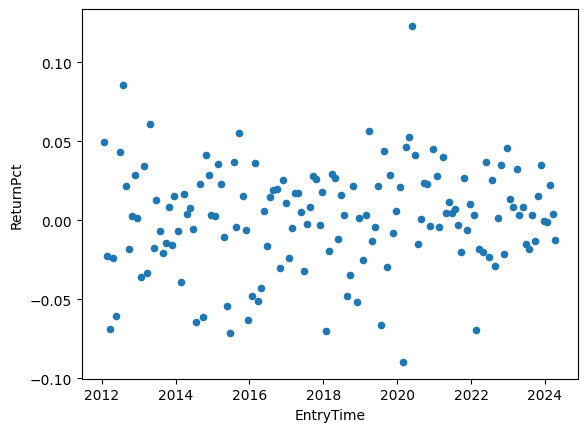

In [11]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [12]:
stats, heatmap = bt.optimize(
    days_before=range(-5, 0, 1),
    days_after=range(1, 6),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [13]:
# heatmap
heatmap.sort_values().iloc[-3:]

days_before  days_after
-5           4             1.040466
-1           5             1.057679
-5           5             1.136310
Name: Profit Factor, dtype: float64

In [14]:
heatmap.groupby(["days_before", "days_after"]).mean().unstack()

days_after,1,2,3,4,5
days_before,,,,,
-5,1.011463,0.956141,1.004379,1.040466,1.136310
-4,0.860646,0.830825,0.892733,0.942298,1.013093
-3,0.777191,0.772892,0.845988,0.880151,0.956669
-2,0.748299,0.740655,0.831834,0.908277,0.997168
-1,0.868793,0.844279,0.927980,0.956968,1.057679


In [15]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-17 00:00:00
Duration                   4489 days 00:00:00
Exposure Time [%]                   46.934189
Equity Final [$]                 116554.24023
Equity Peak [$]                 118940.311184
Return [%]                           16.55424
Buy & Hold Return [%]              193.735337
Return (Ann.) [%]                    1.246973
Volatility (Ann.) [%]                11.35941
Sharpe Ratio                         0.109774
Sortino Ratio                        0.156574
Calmar Ratio                         0.037918
Max. Drawdown [%]                  -32.886439
Avg. Drawdown [%]                   -3.803056
Max. Drawdown Duration     2833 days 00:00:00
Avg. Drawdown Duration      175 days 00:00:00
# Trades                                  148
Win Rate [%]                        56.756757
Best Trade [%]                      12.313994
Worst Trade [%]                     -8.965112
Avg. Trade [%]                    

## The Winner is ...

In [16]:
stats["_strategy"]

<Strategy end_of_month_with_SL(days_before=-5,days_after=5)>

In [17]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(days_before=-4, days_after=5)
bt.plot(superimpose=False, open_browser=False)

Row(id='3829', ...)

In [18]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-17 00:00:00
Duration                   4489 days 00:00:00
Exposure Time [%]                   42.054575
Equity Final [$]                 97475.617395
Equity Peak [$]                 103909.609729
Return [%]                          -2.524383
Buy & Hold Return [%]              193.735337
Return (Ann.) [%]                   -0.206628
Volatility (Ann.) [%]               10.647225
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -34.733468
Avg. Drawdown [%]                  -12.309767
Max. Drawdown Duration     4430 days 00:00:00
Avg. Drawdown Duration     1488 days 00:00:00
# Trades                                  148
Win Rate [%]                        54.054054
Best Trade [%]                       11.20722
Worst Trade [%]                     -7.288105
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [19]:
stats["Win Rate [%]"]

54.054054054054056

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [20]:
stats["Avg. Trade [%]"]

-0.032234840631084616

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [21]:
stats["Profit Factor"]

1.0130933982122647

In [22]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [23]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0544
2,-0.2330
3,-0.0159
4,0.0510
5,-0.0035
6,0.0469
7,-0.0359
8,-0.0312
9,0.0491


<Axes: title={'center': 'Gewinner Trades'}>

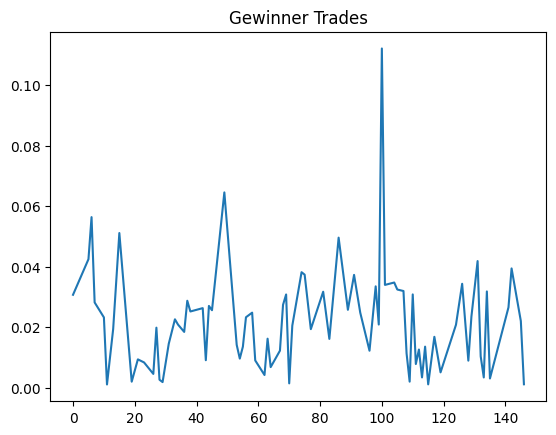

In [24]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

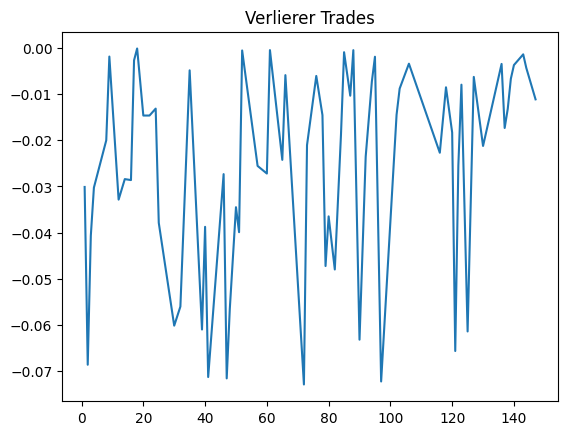

In [25]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [26]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [27]:
bt = Backtest(
    df["2012-01-01":],
    end_of_month_and_skip_month,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run(days_before=-5, days_after=5, skip_month=skip_month)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='5008', ...)

In [28]:
stats

Start                     2012-01-02 00:00:00
End                       2024-04-17 00:00:00
Duration                   4489 days 00:00:00
Exposure Time [%]                    11.87801
Equity Final [$]                143716.438675
Equity Peak [$]                 144931.075394
Return [%]                          43.716439
Buy & Hold Return [%]              193.735337
Return (Ann.) [%]                    2.977441
Volatility (Ann.) [%]                5.763222
Sharpe Ratio                         0.516628
Sortino Ratio                        0.797452
Calmar Ratio                          0.17488
Max. Drawdown [%]                  -17.025654
Avg. Drawdown [%]                   -2.195166
Max. Drawdown Duration     1406 days 00:00:00
Avg. Drawdown Duration      126 days 00:00:00
# Trades                                   37
Win Rate [%]                        81.081081
Best Trade [%]                       5.632746
Worst Trade [%]                      -6.86496
Avg. Trade [%]                    

In [29]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [30]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0943
4,0.0954
11,0.2150


In [31]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,-6599.0
2013,-1992.8
2014,6388.9
2015,3984.6
2016,-13129.7
2017,4358.6
2018,6079.3
2019,8222.7
2020,7787.7


In [32]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012     92543.6
2013     93188.0
2014     97788.3
2015    103881.3
2016     88709.7
2017     91482.4
2018     97030.9
2019    107397.7
2020    117291.0
2021    128349.3
2022    130485.6
2023    143461.5
2024    143716.4
Name: Equity, dtype: float64